In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, jdc, shutil
from tqdm import tqdm

path = '/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy experiments/'
os.chdir(path)

from Scripts.rl_glue_horde import RLGlueHorde
from Scripts.toy_env_horde import ToyEnvironment
from Scripts.oldHorde.toy_horde import Horde
from Scripts.oldHorde.actionValueGVF import ActionValueGVF
import seaborn as sns
import scipy.stats as st
import random
from Scripts.utils import bernouilli_cumulant, gaussian_cumulant, wall_detector_cumulant, gvd_based_cumulant, ReplayBuffer
from Scripts.utils import plot_q_values

path ='/Users/louisserrano/Documents/Oxford/Courses/Trinity/Dissertation/Code/Toy Experiments/Notebooks/GVF'
os.chdir(path)

In [2]:
v_policy3 = np.load("../../policies/v_policy3.npy")
v_opt =  np.load('../../policies/v_pi_opt.npy')

In [3]:
def calc_RMSVE(learned_state_val, true_state_val, state_distribution):
    learned_state_val = np.squeeze(learned_state_val.reshape(-1, 1), -1)
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    learned_state_val = np.nan_to_num(learned_state_val)
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

In [5]:
# Define function to run experiment
def run_experiment_2(filename, horde_info, env_info, gvf, v_pi, horde_parameters, experiment_parameters):
    
    env = ToyEnvironment
    horde = Horde
    rl_glue = RLGlueHorde(env, horde)
    
    for alpha in horde_parameters["alpha"]:
        # save rmsve at the end of each evaluation episode
        # size: num_episode / episode_eval_frequency + 1 (includes evaluation at the beginning of training)

        agent_rmsve = np.zeros(int(experiment_parameters["num_episodes"]/experiment_parameters["episode_eval_frequency"]))
        # save learned state value at the end of each run
        agent_state_val = np.zeros(60)

        # one agent setting
        for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
            np.random.seed(run)
            random.seed(run)
            env_info["seed"] = run
            horde_info["seed"] = run
            horde_info[gvf].update({"alpha" : alpha})
            rl_glue.rl_init(horde_info, env_info)

            for episode in range(1, experiment_parameters["num_episodes"] +1):
                # run episode
                rl_glue.rl_episode(0) # no step limit

                if episode % experiment_parameters["episode_eval_frequency"] == 0:

                    current_V = rl_glue.horde.horde_message("get state values", gvf)
                    current_distribution = rl_glue.horde.horde_message("get state distribution")
                    agent_rmsve[int(episode/experiment_parameters["episode_eval_frequency"])-1] += calc_RMSVE(current_V, v_pi, current_distribution)

            # store only one run of state value
            if run == experiment_parameters["num_runs"]:
                agent_state_val = rl_glue.horde.horde_message("get state values", gvf)

        # rmsve averaged over runs
        agent_rmsve /= experiment_parameters["num_runs"]

        save_name = "{}_alpha_{}".format('GQ', alpha).replace('.','')

        #save_name = 'GTD_lambda_agent'

        if not os.path.exists(filename):
            os.makedirs(filename)
        # save avg. state value
        np.save(filename + "/V_{}".format(save_name), agent_state_val)

        # save avg. rmsve
        np.save(filename + "/RMSVE_{}".format(save_name), agent_rmsve)

In [18]:
policy = np.ones(shape=(6 * 10, 4)) * 0.25
policy_3 = np.zeros((6*10, 4))
policy_3[:,1] = 1

experiment_parameters = {
    "num_episodes" : 1000,
    "num_runs" : 10,
    "episode_eval_frequency" : 1
}
env_info = {
    "end_states" : [[0,8]]
}

horde_parameters = {
    "alpha": [0.0001, 0.005, 0.01, 0.05, 0.1]
}


A_info_1 = {
    "policy": policy_3,
    "control" : False,
    "alpha" : 0.1,
    "lambda" : 0.1,
    "update_freq" : 1,
    "transition_gen" : bernouilli_cumulant}

horde_info = {
    "valueGVF_number" : 0,
    "actionGVF_number" : 1,
    "A1" : A_info_1,
    "policy" : policy
}

In [13]:
filename = 'results/control'
run_experiment_2(filename, horde_info, env_info, "A1", v_opt, horde_parameters, experiment_parameters)

  0%|          | 0/10 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [19]:
def run_experiment(horde_info, 
                   env_info,
                   num_episodes=1,
                   plot_freq = 10,
                   value_error_threshold=1e-8):
    
    env = ToyEnvironment
    horde = Horde
    rl_glue = RLGlueHorde(env, horde)
    rl_glue.rl_init(horde_info, env_info)

    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
        if episode%plot_freq == 0:
            print(episode)
    
    return rl_glue

In [20]:
rl = run_experiment(horde_info, env_info,num_episodes= 1000)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000


In [21]:
q = rl.horde.horde_message("get action values", "A1")

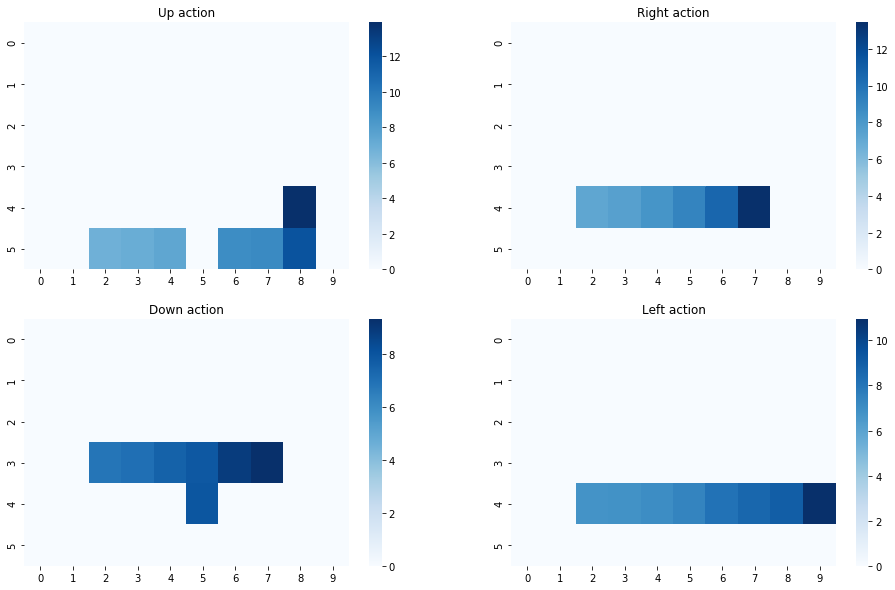

In [23]:
plot_q_values(q)
plt.savefig("results/Q_alpha_01.png", dpi = 300)

In [12]:
v = np.mean(q, -1)

In [14]:
q[33,0]

3.9114725843752085

In [32]:
gvf = rl.horde.GVFs["A1"]

In [33]:
w = gvf.weights

In [34]:
v = gvf.all_state_action_vectors

In [38]:
v[23,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.